In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import copy
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import time
from datetime import datetime

# Add the project root to the path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.utils import extract_trailing_numbers, seed_everything
import flowmol

In [3]:
from torch import Tensor
import torch.nn.functional as F
import dgl

In [4]:
from rdkit import RDLogger
# Hide everything RDKit logs (info/warnings/errors)
for name in ('rdApp.info', 'rdApp.warning', 'rdApp.error'):
    RDLogger.DisableLog(name)

In [5]:
def sampling(config: OmegaConf, model: flowmol.FlowMol, device: torch.device):
    new_molecules = model.sample_random_sizes(
        n_molecules = config.num_samples, 
        n_timesteps = config.num_integration_steps + 1, 
        device = device,
    )
    return new_molecules

In [6]:
def setup_gen_model(flow_model: str, device: torch.device):
    # Load - Flow Model
    gen_model = flowmol.load_pretrained(flow_model)
    gen_model.to(device)
    return gen_model

In [7]:
import argparse

def parse_args():
    parser = argparse.ArgumentParser(description="Run ALM with optional parameter overrides")
    # Settings
    parser.add_argument("--config", type=str, default="../configs/adjoint_matching.yaml",
                        help="Path to config file")
    parser.add_argument("--save_model", action='store_true',
                        help="Save the model, default: false")
    parser.add_argument("--save_samples", action='store_true',
                        help="Create animation of the samples and save the samples, default: false")
    parser.add_argument("--save_plots", action='store_true',
                        help="Save plots of rewards and constraints, default: false")
    parser.add_argument("--plotting_freq", type=int,
                        help="Plotting frequency")
    # FlowMol arguments
    flowmol_choices = ['geom_ctmc', 'geom_gaussian']
    parser.add_argument('--flow_model', type=str, choices=flowmol_choices,
                        help='pretrained model to be used')
    # Adjoint Matching Parameters
    parser.add_argument("--reward_lambda", type=float,
                        help="Override reward_lambda in config")
    parser.add_argument("--lr", type=float,
                        help="Override adjoint_matching.lr in config")
    parser.add_argument("--clip_grad_norm",  type=float,
                        help="Override adjoint_matching.clip_grad_norm in config")
    parser.add_argument("--batch_size", type=int,
                        help="Override adjoint_matching.batch_size in config")
    parser.add_argument("--samples_per_update", type=int,
                        help="Override adjoint_matching.num_samples in config")
    parser.add_argument("--num_integration_steps", type=int,
                        help="Override adjoint_matching.num_integration_steps in config")
    parser.add_argument("--finetune_steps", type=int,
                        help="Override adjoint_matching.finetune_steps in config")
    parser.add_argument("--num_iterations", type=int,
                        help="Override number of iterations")
    return parser.parse_args()

sys.argv = [""]

In [8]:
def update_config_with_args(config, args):
    # FlowMol arguments
    if args.flow_model is not None:
        config.flowmol.model = args.flow_model
    # Adjoint Matching Parameters
    if args.reward_lambda is not None:
        config.reward_lambda = args.reward_lambda
    if args.lr is not None:
        config.adjoint_matching.lr = args.lr
    if args.clip_grad_norm is not None:
        config.adjoint_matching.clip_grad_norm = args.clip_grad_norm
    if args.batch_size is not None:
        config.adjoint_matching.batch_size = args.batch_size
    if args.samples_per_update is not None:
        config.adjoint_matching.sampling.num_samples = args.samples_per_update
    if args.num_integration_steps is not None:
        config.adjoint_matching.sampling.num_integration_steps = args.num_integration_steps
    if args.finetune_steps is not None:
        config.adjoint_matching.finetune_steps = args.finetune_steps
    if args.num_iterations is not None:
        config.adjoint_matching.num_iterations = args.num_iterations
    return config

In [ ]:
import random 

rand_int = random.randint(0, 1e4)
print(rand_int)

In [ ]:
# Parse command line arguments
args = parse_args()

# Load config from file
config_path = Path(args.config)
config = OmegaConf.load(config_path)

# Update config with command line arguments
config = update_config_with_args(config, args)

# Setup - Seed and device and root directory
seed_everything(rand_int)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root_dir = Path(config.root) / Path(config.experiment)

# Settings
if args.plotting_freq is None:
    args.plotting_freq = max(config.adjoint_matching.num_iterations // 20, 1)

# General Parameters
flowmol_model = config.flow_model

# Adjoint Matching Parameters
reward_lambda = config.reward_lambda
learning_rate = config.adjoint_matching.lr
clip_grad_norm = config.adjoint_matching.clip_grad_norm
traj_samples_per_stage = config.adjoint_matching.sampling.num_samples
traj_len = config.adjoint_matching.sampling.num_integration_steps
finetune_steps = config.adjoint_matching.finetune_steps
num_iterations = config.adjoint_matching.num_iterations

config.adjoint_matching.sampling.sampler_type = "memoryless"
config.reward_sampling.sampler_type = "euler"

In [10]:
device

device(type='cpu')

In [11]:
print(OmegaConf.to_yaml(config))

seed: 42
verbose: false
root: /Users/svlg/MasterThesis/v02/
experiment: am_dipole_test
flow_model: geom_gaussian
reward:
  fn: dipole
reward_lambda: 100
adjoint_matching:
  num_iterations: 150
  batch_size: 6
  clip_grad_norm: 0.5
  clip_loss: 100000.0
  lr: 0.0001
  finetune_steps: 4
  sampling:
    sampler_type: memoryless
    num_samples: 24
    num_integration_steps: 40
reward_sampling:
  sampler_type: euler
  num_samples: 30
  num_integration_steps: 100



In [12]:
# Setup - Gen Model
gen_model = setup_gen_model(config.flow_model, device=device)

In [13]:
config.reward_sampling.num_samples = 5

In [14]:
config.reward_sampling

{'sampler_type': 'euler', 'num_samples': 5, 'num_integration_steps': 100}

## Sampling

In [29]:
# Generate Samples
new_molecules = sampling(
    config.reward_sampling,
    copy.deepcopy(gen_model),
    device=device
)

In [30]:
new_molecules

In [31]:
remove_node_keys = ['x_0', 'a_0', 'c_0', 'x_1_pred', 'a_1_pred', 'c_1_pred', 'x_1', 'a_1', 'c_1']
remove_edge_keys = ['e_0', 'e_1_pred', 'e_1']

In [32]:
rdkit_molecules = []
for mol in new_molecules:
    rdkit_molecules.append(mol.rdkit_mol)
    for tmp in remove_node_keys:
        mol.g.ndata.pop(tmp, None)
    for tmp in remove_edge_keys:
        mol.g.edata.pop(tmp, None)

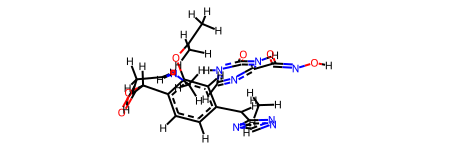

In [33]:
mol0 = new_molecules[0]
mol0.rdkit_mol

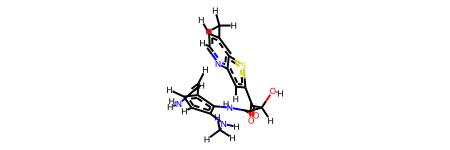

In [35]:
mol1 = new_molecules[1]
mol1.rdkit_mol

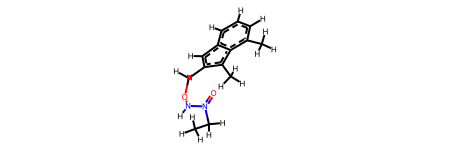

In [36]:
mol2 = new_molecules[2]
mol2.rdkit_mol

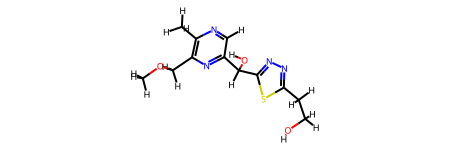

In [37]:
mol3 = new_molecules[3]
mol3.rdkit_mol

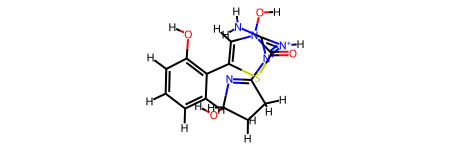

In [38]:
mol4 = new_molecules[4]
mol4.rdkit_mol

#### Shape checking

In [39]:
mol_graph = mol0.g

In [40]:
g = mol0.g

In [42]:
mol_graph.edata["e_t"].shape

torch.Size([4032, 5])

In [45]:
h = torch.cat([
    g.ndata["a_t"],
    g.ndata["c_t"],
    g.ndata["x_t"],
], dim=-1)
h.shape

torch.Size([64, 19])

## Propertiy Prediction

In [46]:
class GNN(nn.Module):
    def __init__(self, node_feats: int, edge_feats: int, hidden_dim=256, depth=6):
        super().__init__()

        self.in_conv = dgl.nn.GraphConv(node_feats, hidden_dim)
        self.edge_linear = nn.Linear(edge_feats, hidden_dim)

        blocks = []
        for _ in range(depth):
            blocks.append(ResBlock(hidden_dim, hidden_dim))
        self.blocks = nn.ModuleList(blocks)

        self.head = nn.Linear(hidden_dim, 1)

        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, g: dgl.DGLGraph) -> Tensor:
        with g.local_scope():
            h = torch.cat([
                g.ndata["a_t"],
                g.ndata["c_t"],
                g.ndata["x_t"],
            ], dim=-1)
            h = self.in_conv(g, h)

            # Add edge feature to initial representation
            g.edata["e"] = self.edge_linear(g.edata["e_t"])

            g.update_all(
                dgl.function.copy_e("e", "m"),    # message: copy each edge's "e" to mailbox "m"
                dgl.function.mean("m", "e_mean")  # reduce: mean over mailbox → store in ndata['e_mean']
            )
            h += g.ndata["e_mean"]

            for block in self.blocks:
                h = block(g, h)

            g.ndata["h"] = h
            h = dgl.readout_nodes(g, "h", op="mean")
            return self.head(h)


class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_dim, out_dim)
        self.norm1 = nn.LayerNorm(out_dim)

        self.conv2 = dgl.nn.GraphConv(out_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim)

        self.skip = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()

    def forward(self, g: dgl.DGLGraph, x: Tensor) -> Tensor:
        h = self.conv1(g, x)
        h = self.norm1(h)
        h = F.silu(h)

        h = self.conv2(g, h)
        h = self.norm2(h)
        h = F.silu(h)

        return h + self.skip(x)

In [47]:
model = GNN(node_feats=19, edge_feats=5).to(device)

In [48]:
model(g)

tensor([[0.]], grad_fn=<AddmmBackward0>)

## RDKIT validity checker

In [49]:
from rdkit.Chem import rdmolops

def is_connected(mol):
    """
    Returns (True/False, fragments).
    fragments is a tuple of tuples of atom indices (one per fragment).
    """
    frags = rdmolops.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    return len(frags) == 1, len(frags)

In [50]:
print(is_connected(mol0.rdkit_mol))
print(is_connected(mol1.rdkit_mol))
print(is_connected(mol2.rdkit_mol))
print(is_connected(mol3.rdkit_mol))
print(is_connected(mol4.rdkit_mol))

(False, 3)
(True, 1)
(True, 1)
(True, 1)
(False, 2)


In [51]:
from rdkit import Chem

def valence_ok(mol):
    """
    Returns (True/False, problems).
    Uses RDKit's sanitization + problem detector to surface valence issues.
    """
    m = Chem.Mol(mol)  # work on a copy
    problems = []
    try:
        # strict=True makes impossible valences raise immediately
        m.UpdatePropertyCache(strict=True)
        # Full sanitization (includes valence checks, aromaticity, etc.)
        Chem.SanitizeMol(m)
        return True, problems
    except Exception as e:
        # If sanitization fails, gather detailed problems
        try:
            # DetectChemistryProblems pinpoints offending atoms/bonds
            probs = rdmolops.DetectChemistryProblems(m)
            for p in probs:
                where = []
                if p.GetAtom() is not None:
                    where.append(f"atom {p.GetAtom().GetIdx()} ({p.GetAtom().GetSymbol()})")
                if p.GetBond() is not None:
                    b = p.GetBond()
                    where.append(f"bond {b.GetIdx()} ({b.GetBeginAtomIdx()}–{b.GetEndAtomIdx()})")
                problems.append(f"{p.GetType()}: {'; '.join(where) if where else 'location n/a'}")
        except Exception:
            # Fallback if detector isn’t available in your RDKit build
            problems.append(str(e))
        return False, problems

In [52]:
counter = 0
for mol in [mol0, mol1, mol2, mol3, mol4]:
    print(f"Checking molecule {counter}")
    ok, issues = valence_ok(mol.rdkit_mol)
    print("Valence/sanitization OK:", ok)
    if not ok:
        print("Issues detected:")
    for line in issues:
        print("  -", line)
    counter += 1

Checking molecule 0
Valence/sanitization OK: False
Issues detected:
  - Explicit valence for atom # 39 C, 5, is greater than permitted
Checking molecule 1
Valence/sanitization OK: False
Issues detected:
Checking molecule 2
Valence/sanitization OK: False
Issues detected:
  - Explicit valence for atom # 29 N, 4, is greater than permitted
Checking molecule 3
Valence/sanitization OK: True
Checking molecule 4
Valence/sanitization OK: False
Issues detected:
  - Explicit valence for atom # 9 N, 5, is greater than permitted


In [53]:
import py3Dmol

for tmp_mol in [mol0, mol1, mol2, mol3, mol4]:
    try:
        pdb_block = Chem.MolToMolBlock(tmp_mol.rdkit_mol)
    except:
        continue
    # Visualize using py3Dmol
    viewer = py3Dmol.view(width=250, height=250)
    viewer.addModel(pdb_block, "mol")
    viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})
    viewer.zoomTo()
    viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [54]:
import re

def _parse_kekulized_atom_count_from_exception(exc_msg: str):
    """
    Extract 'Unkekulized atoms: 7 8 22 ...' -> count, else None.
    """
    if not exc_msg:
        return None
    m = re.search(r"Unkekulized atoms:\s*([0-9\s]+)", exc_msg)
    if not m:
        return None
    return len(re.findall(r"\d+", m.group(1)))

def _infer_problem_type(obj, fallback_other="other"):
    """
    Try to classify a problem object/exception into {'valence','kekul','other'}.
    Works with RDKit problem objects and C++ exception proxies.
    """
    # 1) RDKit problem objects often have GetType()
    try:
        t = (obj.GetType() or "").lower()
    except Exception:
        t = ""
    # 2) Use class name / string as a fallback
    cls = obj.__class__.__name__.lower()
    s   = ""
    try:
        s = str(obj).lower()
    except Exception:
        pass

    text = " ".join([t, cls, s])
    if "valence" in text:
        return "valence"
    if "kekul" in text or "kekulé" in text or "kekulize" in text:
        return "kekul"
    return fallback_other

def score_molecule(mol):
    """
    Returns (score in [0,1], reasons list).

    Policy:
      - If disconnected (fragments > 1): 1.0 immediately.
      - Else try strict cache + full sanitization.
      - If sanitization fails, bucket problems by severity:
          * Valence: base 0.75 + 0.25 * (affected/total)
          * Kekulization: base 0.70 + 0.30 * (affected/total)
          * Other: base 0.60 + 0.40 * (affected/total)
        Combine multiple penalties via: 1 - Π(1 - p_i), then cap at 1.0.
    """
    reasons = []
    n_atoms = mol.GetNumAtoms() or 1  # keep nonzero

    # 1) Connectivity (your hard rule)
    frags = rdmolops.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    if len(frags) > 1:
        reasons.append(f"Disconnected: {len(frags)} fragments")
        return 1.0, reasons

    # 2) Sanitization
    m = Chem.Mol(mol)  # copy
    exc_msg = None
    problems = []
    try:
        m.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(m)
        return 0.0, reasons  # perfect
    except Exception as e:
        exc_msg = str(e)
        try:
            problems = rdmolops.DetectChemistryProblems(m) or []
        except Exception:
            problems = []

    # 3) Collect counts per class, without assuming attributes exist
    buckets = {
        "valence": {"count_atoms": 0, "count_items": 0},
        "kekul":   {"count_atoms": 0, "count_items": 0},
        "other":   {"count_atoms": 0, "count_items": 0},
    }

    for p in problems:
        kind = _infer_problem_type(p)
        if kind not in buckets:
            kind = "other"
        buckets[kind]["count_items"] += 1
        # Only increment atom count if GetAtom exists and returns something
        try:
            if hasattr(p, "GetAtom"):
                a = p.GetAtom()
                if a is not None:
                    buckets[kind]["count_atoms"] += 1
        except Exception:
            pass

    # Special augmentation: kekulization count from exception text
    if (buckets["kekul"]["count_items"] == 0) and exc_msg and ("kekul" in exc_msg.lower()):
        k = _parse_kekulized_atom_count_from_exception(exc_msg)
        buckets["kekul"]["count_items"] = 1
        if k is not None:
            buckets["kekul"]["count_atoms"] = max(buckets["kekul"]["count_atoms"], k)

    # If we had problems but no atom counts at all, make a coarse best-effort:
    if problems and sum(b["count_atoms"] for b in buckets.values()) == 0:
        # Count unique atoms over any problem objects that expose GetAtom
        unique_atoms = set()
        for p in problems:
            try:
                if hasattr(p, "GetAtom"):
                    a = p.GetAtom()
                    if a is not None:
                        unique_atoms.add(a.GetIdx())
            except Exception:
                pass
        coarse = len(unique_atoms)
        if coarse > 0:
            # Distribute roughly evenly across active buckets
            active = [k for k, b in buckets.items() if b["count_items"] > 0]
            per = max(1, coarse // max(1, len(active)))
            for k in active:
                if buckets[k]["count_atoms"] == 0:
                    buckets[k]["count_atoms"] = per

    # 4) Turn buckets into penalties
    penalties = []
    def frac(count):
        return max(0.0, min(1.0, count / n_atoms))

    if buckets["valence"]["count_items"] > 0:
        f = frac(buckets["valence"]["count_atoms"])
        pen = 0.75 + 0.25 * f
        penalties.append(("valence", pen))
        reasons.append(f"Valence problem(s): {buckets['valence']['count_items']} (affected≈{buckets['valence']['count_atoms']}/{n_atoms})")

    if buckets["kekul"]["count_items"] > 0:
        f = frac(buckets["kekul"]["count_atoms"])
        pen = 0.70 + 0.30 * f
        penalties.append(("kekulization", pen))
        reasons.append(f"Kekulization problem(s): {buckets['kekul']['count_items']} (affected≈{buckets['kekul']['count_atoms']}/{n_atoms})")

    if buckets["other"]["count_items"] > 0:
        f = frac(buckets["other"]["count_atoms"])
        pen = 0.60 + 0.40 * f
        penalties.append(("other", pen))
        reasons.append(f"Other chemistry problem(s): {buckets['other']['count_items']} (affected≈{buckets['other']['count_atoms']}/{n_atoms})")

    # Fallback if nothing classified but sanitization failed
    if not penalties and exc_msg:
        penalties.append(("other", 0.65))
        reasons.append("Sanitization failed but problems were not classifiable (fallback penalty).")

    # 5) Combine penalties and cap at 1.0
    prod = 1.0
    for _, p in penalties:
        prod *= (1.0 - max(0.0, min(1.0, p)))
    combined = 1.0 - prod
    combined = max(0.0, min(1.0, combined))
    return combined, reasons

In [56]:
for mol in rdkit_molecules:
    score, reasons = score_molecule(mol)
    print(f"Score: {score:.3f}")
    for r in reasons:
        print("  -", r)


Score: 1.000
  - Disconnected: 3 fragments
Score: 0.733
  - Kekulization problem(s): 1 (affected≈5/46)
Score: 0.925
  - Valence problem(s): 1 (affected≈0/36)
  - Kekulization problem(s): 1 (affected≈0/36)
Score: 0.000
Score: 1.000
  - Disconnected: 2 fragments


## PoseBuster

In [72]:
import numpy as np
import pandas as pd

POSEBUSTERS_COLS_IN_ORDER = [
    "mol_pred_loaded",        # 0.05
    "sanitization",           # 0.50
    "all_atoms_connected",    # 0.30
    "bond_lengths",           # 0.10
    "bond_angles",            # 0.01
    "internal_steric_clash",  # 0.01
    "aromatic_ring_flatness", # 0.01
    "double_bond_flatness",   # 0.01
    "internal_energy",        # 0.01
]

def _coerce_bool(x):
    """Robust truthiness: treat 1/True/'true' as True; 0/False/'false'/NaN as False."""
    if isinstance(x, bool):
        return x
    if pd.isna(x):
        return False
    if isinstance(x, (int, np.integer)):
        return bool(x)
    if isinstance(x, str):
        s = x.strip().lower()
        if s in {"true","t","yes","y","1","pass","passed"}:
            return True
        if s in {"false","f","no","n","0","fail","failed"}:
            return False
    # fallback
    return bool(x)

def _default_weights(cols):
    """
    Heavier weight for earlier checks (given order).
    If exactly the standard PoseBusters columns, use a hand-tuned vector.
    Otherwise, make a simple linear decay and normalize.
    """
    if list(cols) == POSEBUSTERS_COLS_IN_ORDER:
        w = np.array([0.05, 0.50, 0.30, 0.10, 0.01, 0.01, 0.01, 0.01, 0.01], dtype=float)
        w /= w.sum()
        return w
    # generic: linear decay n..1, earlier = larger
    n = len(cols)
    w = np.arange(n, 0, -1, dtype=float)
    w /= w.sum()
    return w

def posebusters_score(df: pd.DataFrame,
                      cols_in_order=POSEBUSTERS_COLS_IN_ORDER,
                      weights: np.ndarray = None,
                      auto_one_on_disconnect: bool = True) -> pd.Series:
    """
    Compute a 0-1 badness score per row.
      - 0 = all tests pass; 1 = none pass.
      - Optional hard rule: if all_atoms_connected == False → 1.0.
      - Otherwise: weighted sum of failed checks (earlier columns weigh more).
    Returns a pandas Series aligned to df.index.
    """
    # Use only columns present; preserve order
    cols = [c for c in cols_in_order if c in df.columns]
    if not cols:
        raise ValueError("None of the expected PoseBusters columns are present.")

    W = _default_weights(cols) if weights is None else np.asarray(weights, dtype=float)
    if W.shape[0] != len(cols):
        raise ValueError(f"weights length ({W.shape[0]}) must match number of used columns ({len(cols)}).")
    W = W / W.sum()  # ensure “all fail” sums to 1.0

    # Coerce to boolean pass/fail
    passes = df[cols].map(_coerce_bool)

    # Hard rule: not sanitized = 1.0
    if auto_one_on_disconnect and "all_atoms_connected" in cols:
        rule = ~passes["sanitization"]
    else:
        rule = pd.Series(False, index=df.index)

    # Weighted failure score
    fails = ~passes
    score = (fails * W).sum(axis=1).astype(float)

    # Apply hard rule
    score = score.where(~rule, 1.0)

    # clip for safety
    return score.clip(0.0, 1.0)

In [73]:
from posebusters import PoseBusters

rdkit_molecules = [mol.rdkit_mol for mol in new_molecules]

buster = PoseBusters(config="mol")
df = buster.bust(rdkit_molecules, None, None, full_report=False)
df

[17:22:08] Explicit valence for atom # 39 C, 5, is greater than permitted
[17:22:08] Explicit valence for atom # 39 C, 5, is greater than permitted
[17:22:08] Explicit valence for atom # 39 C, 5, is greater than permitted
[17:22:08] Explicit valence for atom # 39 C, 5, is greater than permitted
[17:22:08] Can't kekulize mol.  Unkekulized atoms: 20 28 32 36 37
[17:22:08] Can't kekulize mol.  Unkekulized atoms: 20 28 32 36 37
[17:22:08] Can't kekulize mol.  Unkekulized atoms: 20 28 32 36 37
[17:22:08] Can't kekulize mol.  Unkekulized atoms: 20 28 32 36 37
[17:22:08] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:22:08] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:22:08] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:22:08] Explicit valence for atom # 29 N, 4, is greater than permitted
[17:22:08] Explicit valence for atom # 9 N, 5, is greater than permitted
[17:22:08] Explicit valence for atom # 9 N, 5, is greater than permitte

,,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
file,molecule,,,,,,,,,,
<rdkit.Chem.rdchem.Mol object at 0x330641580>,mol_at_pos_0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x330641510>,mol_at_pos_0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x330641660>,mol_at_pos_0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x3306416d0>,mol_at_pos_0,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0
<rdkit.Chem.rdchem.Mol object at 0x3306415f0>,mol_at_pos_0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
df = df.reset_index(drop=True)
df

,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
3,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0
4,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# feedback_df = output from PoseBusters (one row per molecule/pose)
scores = posebusters_score(df)

# If you want the raw float array for training:
y = scores.to_numpy()
y

array([1., 1., 1., 0., 1.])

In [76]:
records = df.to_dict(orient="records")
records

[{'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': False,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': True,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': True,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': True,
  'inchi_convertible': True,
  'all_atoms_connected': True,
  'bond_lengths': 1.0,
  'bond_angles': 1.0,


## XTB-Calulations

In [69]:
import re
import subprocess
from rdkit.Chem import GetPeriodicTable

def extract_dipole(output: str) -> float:
    """
    Extract the total dipole moment (Debye) from xTB output.
    Looks for the 'full:' line under 'molecular dipole'.
    """
    # Pattern: look for 'full:' followed by 3 floats (x, y, z) and then 1 float (total)
    pattern = re.compile(
        r"full:\s+"                # start of line
        r"([-+]?\d*\.\d+|\d+)\s+"  # x
        r"([-+]?\d*\.\d+|\d+)\s+"  # y
        r"([-+]?\d*\.\d+|\d+)\s+"  # z
        r"([-+]?\d*\.\d+|\d+)"     # total dipole
    )
    
    match = pattern.search(output)
    if not match:
        raise ValueError("Dipole not found in xTB output")
    
    # The last group is the total dipole in Debye
    return float(match.group(4))

def extract_homo_lumo(output: str) -> tuple:
    """
    Extract the HOMO-LUMO gap, LUMO, and HOMO energies from xTB output.
    """
    homo = None
    lumo = None
    for line in output.split("\n"):
        if "HOMO" in line:
            homo = float(line.split()[-2])
        elif "LUMO" in line:
            lumo = float(line.split()[-2])
        if (homo is not None) and (lumo is not None):
            return lumo - homo, lumo, homo
    raise ValueError("HOMO or LUMO not found in xtb output.")

def extract_energy(output: str) -> float:
    for line in output.split("\n"):
            if "total energy" in line:
                return float(line.split()[-3])
    raise ValueError("Total energy not found in xtb output.")

def atomic_symbol(z: int) -> str:
    """Convert atomic number (int) to element symbol (str)."""
    pt = GetPeriodicTable()
    return pt.GetElementSymbol(int(z))

def molecule_to_xyz(molecule, format_type, filename="molecule.xyz"):
    """
    Convert a molecule from RDKit, DGL, or PyTorch Geometric format to an XYZ file.
    
    Args:
        molecule: The molecule object (RDKit Mol, DGLGraph, or PyTorch Geometric Data).
        format_type: The format of the molecule ("rdkit" or "dgl").
        filename: The output XYZ filename.
    """
    if format_type == "rdkit":
        # RDKit molecule
        atomic_numbers = [atom.GetAtomicNum() for atom in molecule.GetAtoms()]
        atomic_symbols = [atom.GetSymbol() for atom in molecule.GetAtoms()]
        positions = molecule.GetConformer().GetPositions()
    elif format_type == "dgl":
        # DGL graph
        atomic_numbers = torch.argmax(molecule.ndata['a_1'], dim=-1).numpy()
        atomic_symbols = [atomic_symbol(z) for z in atomic_numbers]
        positions = molecule.ndata['x_1'].numpy()
    else:
        raise ValueError("Unsupported format type. Use 'rdkit' or 'dgl'.")

    # Write to XYZ file
    with open(filename, "w") as f:
        f.write(f"{len(atomic_numbers)}\n")
        f.write("Generated by molecule_to_xyz\n")
        for symbol, pos in zip(atomic_symbols, positions):
            f.write(f"{symbol} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

def run_xtb(xyz_file):
    """
    Run xtb on an XYZ file and extract the HOMO-LUMO gap, dipole and energy.
    """
    # Run xtb
    result = subprocess.run(["xtb", xyz_file], capture_output=True, text=True)
    output = result.stdout
    
    rtn_dict = {}
    # homolumo
    tmp = extract_homo_lumo(output)
    rtn_dict["homolumo_gap"] = tmp[0]
    rtn_dict["lumo"] = tmp[1]
    rtn_dict["homo"] = tmp[2]
    # dipole
    rtn_dict["dipole"] = extract_dipole(output)
    # energy
    rtn_dict["energy"] = extract_energy(output)

    return rtn_dict

def compute_true_reward(molecule, format_type):
    """
    Compute a homolumo, dipole, and energy for a molecule using xtb.

    Args:
        molecule: The molecule object (RDKit Mol or DGLGraph).
        format_type: The format of the molecule ("rdkit" or "dgl").
    Returns:
        A dictionary containing the computed quantities.
    """
    # Convert molecule to XYZ file
    xyz_file = "temp_molecule.xyz"
    molecule_to_xyz(molecule, format_type, xyz_file)

    # Run xtb and compute the quantity
    value = run_xtb(xyz_file)

    # Clean up temporary file
    subprocess.run(["rm", xyz_file])
    subprocess.run(["rm", "charges"])
    subprocess.run(["rm", "wbo"])
    subprocess.run(["rm", "xtbrestart"])
    subprocess.run(["rm", "xtbtopo.mol"])

    return value

In [77]:
properties = []
for tmp_mol in rdkit_molecules:
    num_atoms = tmp_mol.GetNumAtoms()
    print(f"Molecule with {num_atoms} atoms:")
    rtn_dict = compute_true_reward(tmp_mol, "rdkit")
    homolumo_gap, lumo, homo = rtn_dict["homolumo_gap"], rtn_dict["lumo"], rtn_dict["homo"]
    print(f"HOMO-LUMO Gap: {homolumo_gap:.4f} eV")
    print(f"LUMO: {lumo:.4f} eV, HOMO: {homo:.4f} eV")
    print(f'Energy: {rtn_dict["energy"]:.4f} eV')
    print(f'Dipole moment: {rtn_dict["dipole"]:.4f} Debye')
    print()
    properties.append(rtn_dict)

Molecule with 64 atoms:
HOMO-LUMO Gap: 0.0066 eV
LUMO: -9.0811 eV, HOMO: -9.0877 eV
Energy: -108.7026 eV
Dipole moment: 11.7280 Debye

Molecule with 46 atoms:
HOMO-LUMO Gap: 0.3824 eV
LUMO: -8.4164 eV, HOMO: -8.7988 eV
Energy: -77.4028 eV
Dipole moment: 4.6580 Debye

Molecule with 36 atoms:
HOMO-LUMO Gap: 0.1457 eV
LUMO: -8.0467 eV, HOMO: -8.1924 eV
Energy: -52.8910 eV
Dipole moment: 7.8330 Debye

Molecule with 36 atoms:
HOMO-LUMO Gap: 2.4483 eV
LUMO: -7.3855 eV, HOMO: -9.8338 eV
Energy: -60.9395 eV
Dipole moment: 5.1340 Debye

Molecule with 40 atoms:
HOMO-LUMO Gap: 0.1286 eV
LUMO: -6.5967 eV, HOMO: -6.7253 eV
Energy: -71.8159 eV
Dipole moment: 5.9310 Debye



In [79]:
properties

[{'homolumo_gap': 0.006600000000000605,
  'lumo': -9.0811,
  'homo': -9.0877,
  'dipole': 11.728,
  'energy': -108.702615081413},
 {'homolumo_gap': 0.3824000000000005,
  'lumo': -8.4164,
  'homo': -8.7988,
  'dipole': 4.658,
  'energy': -77.402783891288},
 {'homolumo_gap': 0.14569999999999972,
  'lumo': -8.0467,
  'homo': -8.1924,
  'dipole': 7.833,
  'energy': -52.891007752244},
 {'homolumo_gap': 2.4482999999999997,
  'lumo': -7.3855,
  'homo': -9.8338,
  'dipole': 5.134,
  'energy': -60.939512989715},
 {'homolumo_gap': 0.1285999999999996,
  'lumo': -6.5967,
  'homo': -6.7253,
  'dipole': 5.931,
  'energy': -71.815891369023}]

In [83]:
df_props = pd.DataFrame.from_records(properties)
df_extra = pd.concat([df, df_props], axis=1)

In [84]:
df_extra

,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy,homolumo_gap,lumo,homo,dipole,energy
0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0066,-9.0811,-9.0877,11.728,-108.702615
1,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,0.3824,-8.4164,-8.7988,4.658,-77.402784
2,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,0.1457,-8.0467,-8.1924,7.833,-52.891008
3,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,2.4483,-7.3855,-9.8338,5.134,-60.939513
4,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0.1286,-6.5967,-6.7253,5.931,-71.815891


## Saving and Loading

In [ ]:
import pickle, gzip

def dump_pickle(path, mols):
    with gzip.open(path, "wb") as f:
        pickle.dump(mols, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def load_pickle(path):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

In [85]:
for i, mol in enumerate(new_molecules):
    dump_pickle(f"mols_{i}.pkl.gz", mol)

In [94]:
path = "/Users/svlg/MasterThesis/v03_geom/data/0901_1013_gen_data_10"
train_df = pd.read_csv(f"{path}/results.csv")

In [95]:
train_df

,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy,score,homolumo_gap,lumo,homo,dipole,energy,id_str
0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0322,-5.9396,-7.9718,2.813,-61.505620,mol_000000
1,True,True,True,False,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.3613,-8.2539,-8.6152,2.753,-64.158520,mol_000001
2,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0799,-9.4665,-9.5464,10.588,-66.662724,mol_000002
3,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.6028,-9.0304,-9.6332,8.647,-65.191024,mol_000003
4,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.9885,-8.9789,-9.9674,7.947,-83.535808,mol_000004
5,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.5955,-9.5506,-10.1461,5.392,-68.150779,mol_000005
6,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.1219,-9.3091,-9.4310,5.562,-101.462077,mol_000006
7,True,True,True,False,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.1014,-7.4961,-7.5975,1.764,-72.222583,mol_000007
8,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.3841,-7.1161,-8.5002,4.375,-85.046991,mol_000008
9,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.5712,-8.3670,-8.9382,13.147,-94.419896,mol_000009


In [ ]:
idx = 0
mol_path = f"{path}/molecules/{train_df.iloc[idx]['id_str']}.bin"
mols_back, aux = dgl.load_graphs(mol_path)

In [98]:
aux

{}

In [99]:
mols_back

[Graph(num_nodes=43, num_edges=1806,
       ndata_schemes={'c_t': Scheme(shape=(6,), dtype=torch.float32), 'a_t': Scheme(shape=(10,), dtype=torch.float32), 'x_t': Scheme(shape=(3,), dtype=torch.float32)}
       edata_schemes={'ue_mask': Scheme(shape=(), dtype=torch.uint8), 'e_t': Scheme(shape=(5,), dtype=torch.float32)})]

In [68]:
mols_back[0].g

Graph(num_nodes=64, num_edges=4032,
      ndata_schemes={'x_t': Scheme(shape=(3,), dtype=torch.float32), 'a_t': Scheme(shape=(10,), dtype=torch.float32), 'c_t': Scheme(shape=(6,), dtype=torch.float32)}
      edata_schemes={'e_t': Scheme(shape=(5,), dtype=torch.float32), 'ue_mask': Scheme(shape=(), dtype=torch.bool)})

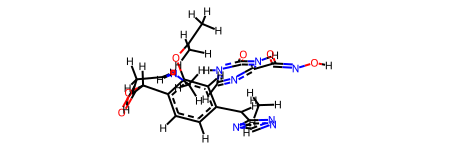

In [64]:
mols_back[0].rdkit_mol

### Saving format